In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind

## Готовим данные

In [2]:
ab_df = pd.read_csv('Dataset_AB_TEST.csv', sep = ';')

Смотрим на данные

In [3]:
def statistical_analysis(numbers, q=[0.1,0.25,0.3,0.4,0.5,0.6,0.75,0.9]):
    if isinstance(numbers, (list, tuple)) == False: #проверяем, что на входе спсок или кортеж
        return print('Нужен список или кортеж!')
    if len(numbers) <= 4: #проверяем длину ряда
        return print('Требуется более длинный ряд')
    #считаем среднее, дисперсию,ст. откл
    num_series = pd.Series(numbers)
    mean = num_series.mean()
    var = num_series.var()
    std = num_series.std()
    print(f'Среднее значение: {mean}, Дисперсия: {var}, Стандартное отклонение: {std}')
    #квантильный анализ
    median = st.median(num_series)
    quantiles = np.quantile(num_series, q)
    int_r = np.quantile(num_series, 0.75) - np.quantile(num_series, 0.25)
    print(f'Медиана: {median}, Первый квартиль: {np.quantile(num_series, 0.25)}, Второй квартиль: {np.quantile(num_series, 0.5)},' , \
          f'Третий квартиль: {np.quantile(num_series, 0.75)}, Четвертый квартиль: {np.quantile(num_series, 1)}, ' \
          f'Межквартильный размах: {int_r}, Децили: {np.quantile(num_series, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])}')
    #гистограмма
    sns.histplot(data = num_series)
    #общий ретерн
    return mean, var, std, median, quantiles, int_r

In [4]:
#почистим данные от пропусков
ab_df.dropna(inplace = True)

Среднее значение: 3568.7580258302582, Дисперсия: 8568932.941996625, Стандартное отклонение: 2927.27397795229
Медиана: 3173.5, Первый квартиль: 1250.75, Второй квартиль: 3173.5, Третий квартиль: 5356.5, Четвертый квартиль: 24797.0, Межквартильный размах: 4105.75, Децили: [  410.    872.8  1590.   2329.6  3173.5  3934.   4810.   5967.   7088.2
 24797. ]


(3568.7580258302582,
 8568932.941996625,
 2927.27397795229,
 3173.5,
 array([ 410.  , 1250.75, 1590.  , 2329.6 , 3173.5 , 3934.  , 5356.5 ,
        7088.2 ]),
 4105.75)

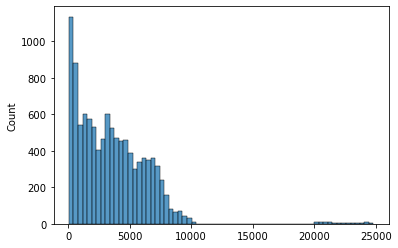

In [5]:
statistical_analysis(ab_df['sum_pay'].tolist())

Судя по гистограмме, у нас идут выбросы после 20.000. Удалим их.



In [6]:
drop_list = ab_df.loc[ab_df['sum_pay'] >= 20_000].index.tolist()
ab_df.drop(index = drop_list, inplace = True)

Првоерим, что мы избавились от выбросов

Среднее значение: 3431.3779388532666, Дисперсия: 6023895.900736336, Стандартное отклонение: 2454.3626261692334
Медиана: 3155.0, Первый квартиль: 1237.0, Второй квартиль: 3155.0, Третий квартиль: 5274.0, Четвертый квартиль: 10141.0, Межквартильный размах: 4037.0, Децили: [  409.   863.  1576.  2307.  3155.  3899.  4769.  5880.  7011. 10141.]


(3431.3779388532666,
 6023895.900736336,
 2454.3626261692334,
 3155.0,
 array([ 409., 1237., 1576., 2307., 3155., 3899., 5274., 7011.]),
 4037.0)

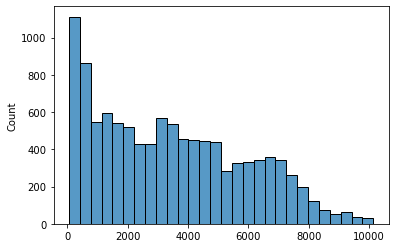

In [7]:
statistical_analysis(ab_df['sum_pay'].tolist()) #успех!

## Анализируем АБ-тест

Напишем простенькую функцию для визуализации данных

In [8]:
def show_hist(a, b):
    plt.figure(figsize = (10, 10))
    sns.histplot(a, color='purple', label = 'Контрольная группа')
    sns.histplot(b, color='orange', label = 'Тестовая группа')
    plt.legend()
    plt.show()

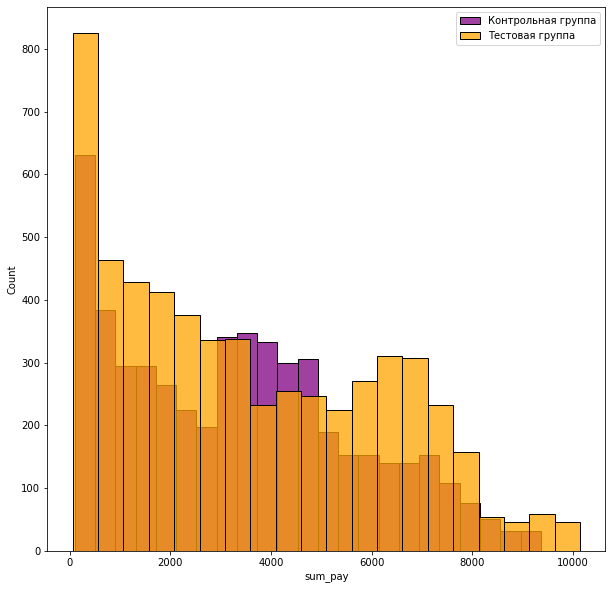

In [9]:
ctrl_group = ab_df.loc[ab_df['id_group'] == 'control']
test_group = ab_df.loc[ab_df['id_group'] == 'test']
show_hist(ctrl_group['sum_pay'], test_group['sum_pay'])

График выглядит так, будто в тестовой группе (рыжая зона) выросли продажи на концах распределения. Применим тесты для проверки.

In [10]:
def mann_whitney_func(a, b, alpha = 0.05):
    m_w_stat, m_w_p = stats.mannwhitneyu(x=a, y=b, alternative = 'two-sided')
    if m_w_p > alpha:
        print('Распределения равны')
    else:
        print('Распределения не равны')
    return m_w_stat, m_w_p

In [11]:
def two_samp_ttest(a, b, alpha = 0.05):
    t_stat, p_value = ttest_ind(a, b)
    print(f'Значение двухвыборочного t-критерия: {round(t_stat, 2)}, p-value: {round(p_value, 2)}')
    if p_value < alpha:
        print('Принимается альтернативная гипотеза H1 (средние не равны)')
    else:
        print('Принимается нулевая гипотеза H0 (средние равны)')
    return t_stat, p_value

In [12]:
mann_whitney_func(ctrl_group['sum_pay'], test_group['sum_pay'])

Распределения равны


(14141330.5, 0.05842125879702285)

In [13]:
two_samp_ttest(ctrl_group['sum_pay'], test_group['sum_pay'])

Значение двухвыборочного t-критерия: -3.71, p-value: 0.0
Принимается альтернативная гипотеза H1 (средние не равны)


(-3.7141912292177888, 0.0002048855494553075)

In [14]:
ctrl_group['sum_pay'].describe()

count    5140.000000
mean     3339.535409
std      2292.092741
min       101.000000
25%      1281.750000
50%      3247.500000
75%      4857.500000
max      9362.000000
Name: sum_pay, dtype: float64

In [15]:
test_group['sum_pay'].describe()

count     5621.000000
mean      3515.361324
std       2591.232452
min         59.000000
25%       1206.000000
50%       3046.000000
75%       5763.000000
max      10141.000000
Name: sum_pay, dtype: float64

**Итак, в тестовой и контрольной группе оказались одинаковые распределения, но на статистически значимом уровне разные средние. Значит, на основе АБ-теста мы можем судить о росте продаж в тестовой группе.**

## Анализ теста в разрезе торговых точек

In [16]:
selling_points = pd.unique(ab_df['id_point'])

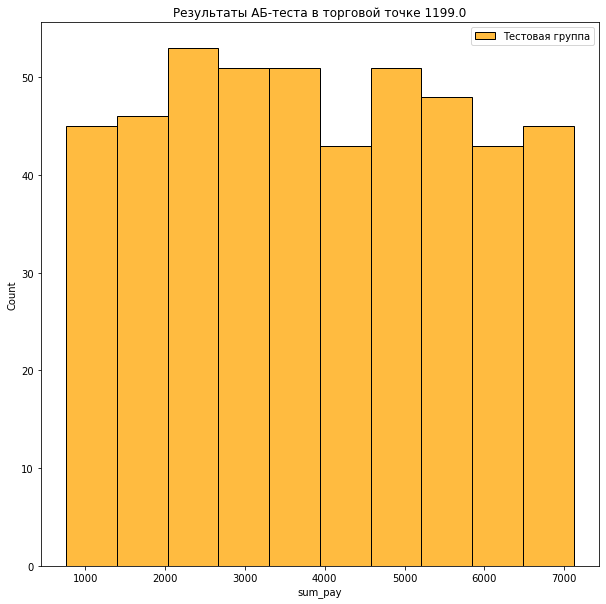

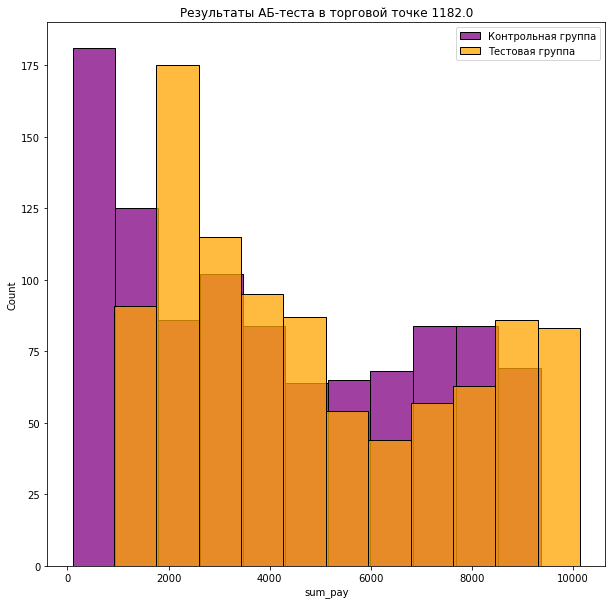

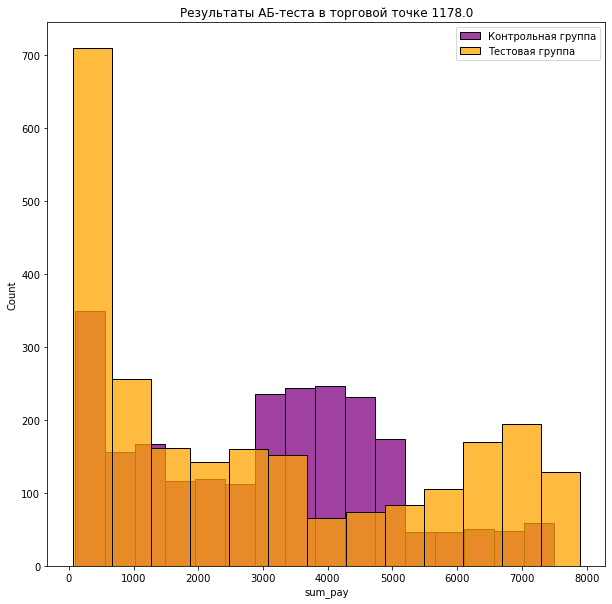

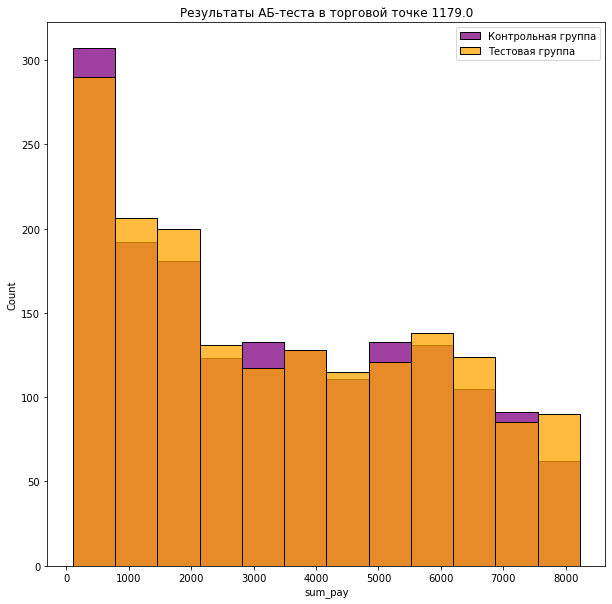

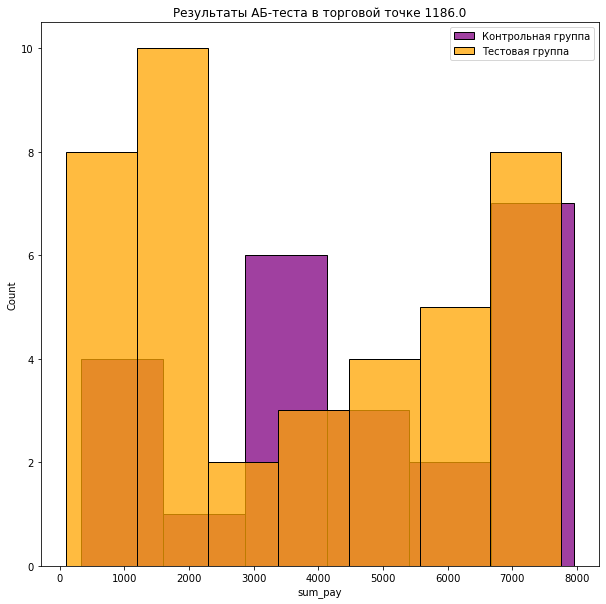

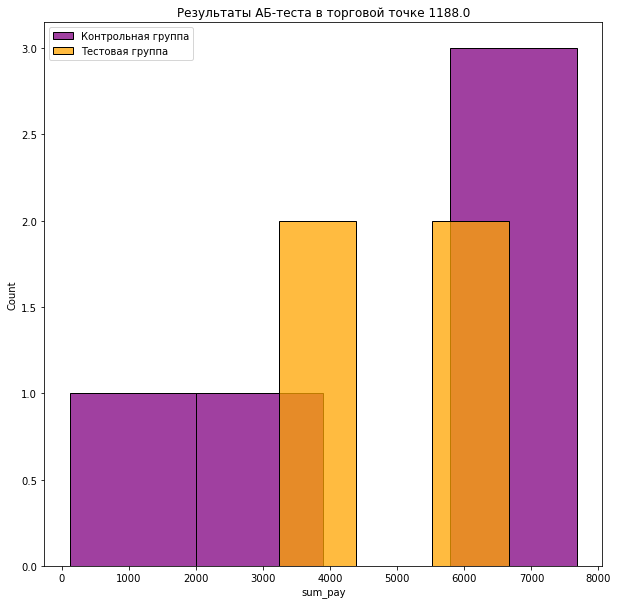

In [17]:
for point in selling_points:
    plt.figure(figsize = (10, 10))
    sns.histplot(ctrl_group.loc[ctrl_group['id_point'] == point]['sum_pay'], color='purple', label = 'Контрольная группа')
    sns.histplot(test_group.loc[test_group['id_point'] == point]['sum_pay'], color='orange', label = 'Тестовая группа')
    plt.title('Результаты АБ-теста в торговой точке {}'.format(point))
    plt.legend()
    plt.show()

Посмотрим наполненность групп

In [18]:
ab_df.groupby(['id_point','id_group'])['sum_pay'].count()

id_point  id_group
1178.0    control     2403
          test        2406
1179.0    control     1697
          test        1745
1182.0    control     1012
          test         950
1186.0    control       23
          test          40
1188.0    control        5
          test           4
1199.0    test         476
Name: sum_pay, dtype: int64

В точке **1186** довольно мало продаж в выборке, при этом в контрольной группе их в два раза меньше, чем в тестовой. 
Очень мало продаж в **1188**. 
В **1199** по какой-то причине не оказалось контрольной группы.

In [19]:
s_points = np.delete(selling_points, [0]) #мы не можем провести тесты для точки 1199 (у нее нет контр. группы), поэтому уберем ее из списка
for point in s_points:
    print(f'Результаты для точки {point}:')
    a = ctrl_group.loc[ctrl_group['id_point'] == point]
    b = test_group.loc[test_group['id_point'] == point]
    mann_whitney_func(a['sum_pay'], b['sum_pay'])
    two_samp_ttest(a['sum_pay'], b['sum_pay'])

Результаты для точки 1182.0:
Распределения не равны
Значение двухвыборочного t-критерия: -7.17, p-value: 0.0
Принимается альтернативная гипотеза H1 (средние не равны)
Результаты для точки 1178.0:
Распределения не равны
Значение двухвыборочного t-критерия: 1.53, p-value: 0.13
Принимается нулевая гипотеза H0 (средние равны)
Результаты для точки 1179.0:
Распределения равны
Значение двухвыборочного t-критерия: -1.12, p-value: 0.26
Принимается нулевая гипотеза H0 (средние равны)
Результаты для точки 1186.0:
Распределения равны
Значение двухвыборочного t-критерия: 1.35, p-value: 0.18
Принимается нулевая гипотеза H0 (средние равны)
Результаты для точки 1188.0:
Распределения равны
Значение двухвыборочного t-критерия: 0.14, p-value: 0.9
Принимается нулевая гипотеза H0 (средние равны)


**Итак, статистически значимые различия в среднем чеке оказались только в точке 1182. Несмотря на то, что в точке 1178 оказались весьма разные распределения (что видно из графика выше), средние чеки оказались равны на статистически значимом уровне. Скорее всего, так получилось из-за прироста значений на концах распределения и падения в центре. Результаты теста для 1188 вряд ли можно считать надежными из-за малого количества кейсов.**

In [20]:
print(ctrl_group.loc[ctrl_group['id_point'] == 1182]['sum_pay'].mean())
print(test_group.loc[test_group['id_point'] == 1182]['sum_pay'].mean())

4036.9426877470355
4945.12947368421


Ниже я из любопытства провела bootstrap для точки 1178, однако результат оказался тем же - на статистически значимом уровне разницы в среднем чеке не оказалось.

In [21]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

In [22]:
boot_results_1178 = bs.bootstrap_ab(test = test_group.loc[test_group['id_point'] == 1178]['sum_pay'].values, ctrl = ctrl_group.loc[ctrl_group['id_point'] == 1178]['sum_pay'].values
                              ,stat_func = bs_stats.mean
                              ,compare_func = bs_compare.difference
                              ,return_distribution=True)
borders = np.percentile(boot_results_1178, [2.5, 97.5])

C:\Users\deado\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


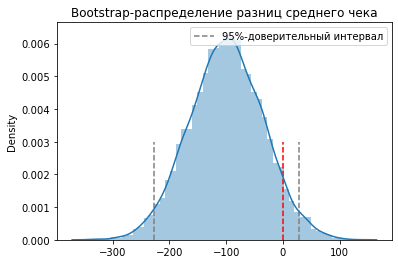

In [23]:
sns.distplot(boot_results_1178) # функция построения распределения
plt.title('Bootstrap-распределение разниц среднего чека')
plt.rcParams["figure.figsize"] = (12, 6)
plt.vlines(0, # отрисуем линию на уровне ноля
           ymin = 0, 
           ymax = 0.003, 
           linestyles= '--', 
           colors = 'red')
plt.vlines(borders, # отрисуем перцентили
           ymin = 0, 
           ymax = 0.003, 
           linestyles= '--', 
           colors = 'grey', 
           label = '95%-доверительный интервал')
plt.legend()
plt.show()

## Сегментация по длительности регистрации

In [24]:
pear_cor_coef, pear_p = stats.pearsonr(ab_df['sum_pay'], ab_df['months_reg'])
sp_cor_coef, sp_p = stats.spearmanr(ab_df['sum_pay'], ab_df['months_reg'])
print(f'p-value Пирсона: {pear_p}, коэф. Пирсона: {pear_cor_coef}; p-value Спирмана: {sp_p}, коэф. Спирмана: {sp_cor_coef}')

p-value Пирсона: 0.0, коэф. Пирсона: 0.598276252133036; p-value Спирмана: 0.0, коэф. Спирмана: 0.6520008575703581


**Наблюдается положительная корреляция средней силы (по Пирсону и по Спирману) между длительностью регистрации и суммой платежа.**